In [15]:
import os

gpu_num = "0"  # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ['DRJIT_LIBLLVM_PATH'] = 'E:\\Program\ Files\\LLVM\\bin\\LLVM-C.dll'

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try:  # detect if the notebook runs in Colab
    import google.colab

    colab_compat = True  # deactivate preview
except:
    colab_compat = False

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

import mitsuba as mi
mi.set_variant("llvm_ad_rgb")

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os

    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel("ERROR")

tf.random.set_seed(
    1
)  # Set global random seed for reproducibility

In [16]:
# Import Sionna RT components
import geopandas as gpd
import numpy as np
import numpy.typing
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

from src.classes.BostonTwin import BostonTwin
from pathlib import Path

import geopandas as gpd
import numpy as np
import numpy.typing


# BostonTwin

BostonTwin is a dataset that merges a high-fidelity 3D model of the city of Boston, MA, with the existing geospatial data on cellular base stations deployments, in a ray-tracing-ready format. Thus, BostonTwin enables not only the instantaneous rendering and programmatic access to the building models, but it also allows for an accurate representation of the electromagnetic propagation environment in the real-world city of Boston.

## Quickstart

### Initialize and visualize BostonTwin

Create the BostonTwin object by specifying the path of the dataset. The dataset can be downloaded from <http://hdl.handle.net/2047/D20623157>.

In [17]:
dataset_dir = Path("bostontwin")
bostwin = BostonTwin(dataset_dir)

102 scenes imported.


We can get a list of currently available scenes through the `get_scene_names` method.

In [18]:
scene_names = bostwin.get_scene_names()

scene_names.sort()

print(f"There are {len(scene_names)} scenes available in {dataset_dir}.\n{scene_names}")

There are 102 scenes available in bostontwin.
['BOS_A_10', 'BOS_B_10', 'BOS_B_11', 'BOS_B_4', 'BOS_B_5', 'BOS_B_6', 'BOS_B_8', 'BOS_B_9', 'BOS_C_10', 'BOS_C_11', 'BOS_C_4', 'BOS_C_5', 'BOS_C_6', 'BOS_C_8', 'BOS_C_9', 'BOS_D_10', 'BOS_D_11', 'BOS_D_12', 'BOS_D_3', 'BOS_D_4', 'BOS_D_5', 'BOS_D_6', 'BOS_D_7', 'BOS_D_8', 'BOS_D_9', 'BOS_E_10', 'BOS_E_11', 'BOS_E_12', 'BOS_E_3', 'BOS_E_4', 'BOS_E_5', 'BOS_E_6', 'BOS_E_7', 'BOS_E_8', 'BOS_E_9', 'BOS_F_10', 'BOS_F_11', 'BOS_F_12', 'BOS_F_4', 'BOS_F_5', 'BOS_F_6', 'BOS_F_7', 'BOS_F_8', 'BOS_F_9', 'BOS_G_10', 'BOS_G_11', 'BOS_G_2', 'BOS_G_3', 'BOS_G_4', 'BOS_G_5', 'BOS_G_6', 'BOS_G_7', 'BOS_G_8', 'BOS_G_9', 'BOS_H_10', 'BOS_H_11', 'BOS_H_2', 'BOS_H_3', 'BOS_H_4', 'BOS_H_5', 'BOS_H_6', 'BOS_H_7', 'BOS_H_8', 'BOS_H_9', 'BOS_I_10', 'BOS_I_2', 'BOS_I_3', 'BOS_I_4', 'BOS_I_5', 'BOS_I_6', 'BOS_I_7', 'BOS_I_8', 'BOS_I_9', 'BOS_J_2', 'BOS_J_3', 'BOS_J_4', 'BOS_J_5', 'BOS_J_6', 'BOS_J_7', 'BOS_J_9', 'BOS_K_1', 'BOS_K_2', 'BOS_K_3', 'BOS_K_4', 'BOS_K_5',

Select one scene by specifying its name

In [19]:
scene_name = "BOS_G_5"

and load it

In [21]:
sionna_scene, scene_antennas = bostwin.load_bostontwin(scene_name)

RuntimeError: ​[xml.cpp:179] Error while loading "E:\Cip\Documents\School\Semester7\ECOMMS\boston_twin_FL\bostontwin\boston3d\BOS_G_5.xml" (at line 14, col 5): resource deadlock would occur: resource deadlock would occur.

The BostonTwin is fully compatible with Sionna. For a given scene, `load_bostontwin` method returns the Sionna scene and the corresponding antennas.

#### 3D Models

The `plot_buildings` method shows the 2D footprint of the buildings in the scene:

<Axes: title={'center': 'BOS_G_5'}, xlabel='Longitude', ylabel='Latitude'>

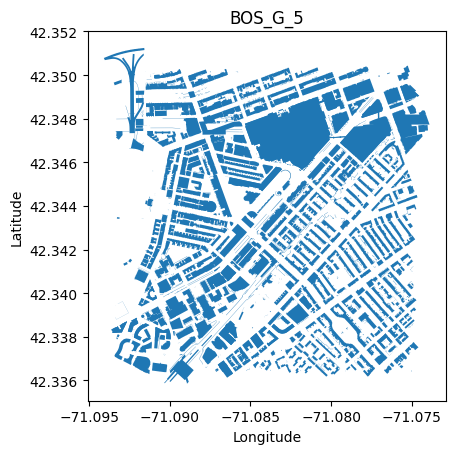

In [22]:
bostwin.plot_buildings(basemap=False)

and the corresponding 3D models be already previewed using the Sionna `preview`:

In [23]:
sionna_scene.preview()

NameError: name 'sionna_scene' is not defined

#### Antennas

The second component of BostonTwin is the antennas around the city. The `scene_antennas` variable returned by the `load_bostontwin` method is a geopandas `GeoDataFrame` that contains all the information on the antennas in the area of the currently loaded scene.

In [24]:
n_antennas = scene_antennas.shape[0]
print(f"There are {n_antennas} antennas in the {scene_name} scene.")

NameError: name 'scene_antennas' is not defined

Similarly to the 3D models, we can also show the location of the antennas in the scene:

<Axes: title={'center': 'BOS_G_5'}, xlabel='Longitude', ylabel='Latitude'>

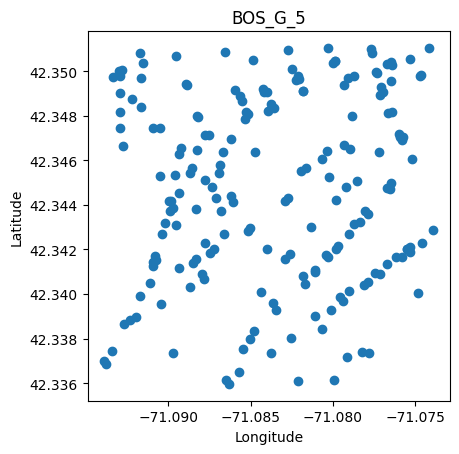

In [25]:
bostwin.plot_antennas(basemap=False)

Then, we need to spawn the antennas in the Sionna scene. We provide an example to do that, to be adjusted to one's need.

In [26]:
n_txs = 30  # number of transmitters
if n_txs>n_antennas:
    raise ValueError(f"There are {n_antennas} in the scene. Please select a number of transmitters lower than {n_antennas}")
n_rxs = n_antennas - n_txs  # set the antennas that are not transmitters to be receivers 

# select the antennas from scene_antennas using their indices 
ant_ids = np.arange(n_antennas)
tx_ids = np.sort(np.random.choice(ant_ids, size=n_txs, replace=False))  # pick n_txs random indices for the transmitters
rx_ids = np.setdiff1d(ant_ids,tx_ids)  # the rest are receivers 
print(f"Transmitter IDs: {tx_ids}\nReceivers IDs:{rx_ids}")

NameError: name 'n_antennas' is not defined

Configure the transmitter and receiver antennas (see Sionna documentation and tutorials): 

In [ ]:
# Configure antenna array for all transmitters
sionna_scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Configure antenna array for all receivers
sionna_scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="cross")

and add them as `Radio Devices` into the Sionna scene using the `add_scene_antennas` method: 

In [ ]:
# remove existing Radio Devices
[sionna_scene.remove(tx) for tx in sionna_scene.transmitters]
[sionna_scene.remove(rx) for rx in sionna_scene.receivers]

# add the antennas to the BostonTwin
tx_rx_dict = bostwin.add_scene_antennas(tx_ids,rx_ids)

#### BostonTwin

All the elements of BostonTwin are now loaded, and we can plot it on the 2D geographic map

In [ ]:
bostwin.plot_twin(basemap=False)

interact with the preview

In [ ]:
sionna_scene.preview(show_devices=True)

or rendered it from a camera, defined through the Sionna API  

Note: on CPU, the rendering might take a while and require several GBs of RAM, depending on the size and number of objects in the scene.

In [ ]:
render_cam = Camera("render_cam",position=[-300, -500, 150])
sionna_scene.add(render_cam)
render_cam.look_at([500, 700, 0])

In [ ]:
resolution = [480, 320]  # increase for higher quality of renderings
sionna_scene.render(render_cam, show_devices=True, resolution=resolution)

### Creating custom scenes

Bostontwin contains many predefined scenes corresponding to the tiles defined by the BPDA of Boston.
The user can create custom scenes by specifying the longitude and latitude of the center and a radius using the `generate_scene_from_radius` method.

In [ ]:
new_scene_name = "nu_campus"  # name of the scene
center = [-71.08730583197658, 42.33713805318744]  # center of the scene
radius = 500  # radius of the scene

bostwin.generate_scene_from_radius(scene_name=new_scene_name,
                                   center_lon=center[0],
                                   center_lat=center[1],
                                   side_m=radius,
                                  )

Once created, we can load and use it in the same way as the other scenes.

In [ ]:
sionna_scene, scene_antennas = bostwin.load_bostontwin(new_scene_name)
bostwin.plot_twin(basemap=False)

### Ray Tracing

For an in-depth overview of the Sionna Ray Tracer, we refer to the [original documentation](https://nvlabs.github.io/sionna/api/rt.html#ray-tracing). Here, we report a simple example.

In [ ]:
n_antennas = scene_antennas.shape[0]
print(f"There are {n_antennas} antennas in the {new_scene_name} scene.")

In [ ]:
n_txs = 5  # number of transmitters
n_rxs = 5  # number of receivers

# select the antennas from scene_antennas using their indices 
ant_ids = np.arange(n_antennas)
tx_ids = np.sort(np.random.choice(ant_ids, size=n_txs, replace=False))  # pick n_txs random indices for the transmitters
rx_ids = np.sort(np.random.choice(np.setdiff1d(ant_ids,tx_ids), size=n_txs, replace=False))  # the rest are receivers 
print(f"Transmitter IDs: {tx_ids}\nReceivers IDs:{rx_ids}")

# Configure antenna array for all transmitters
sionna_scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Configure antenna array for all receivers
sionna_scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="cross")

# add the antennas to the BostonTwin
tx_rx_dict = bostwin.add_scene_antennas(tx_ids,rx_ids)

In [ ]:
paths = sionna_scene.compute_paths(
                    max_depth=2,
                    num_samples=1e5,
                    reflection=True,
                    diffraction=True,
                    scattering=True,
                   )

In [ ]:
sionna_scene.preview(paths, show_devices=True, show_paths=True)

In [ ]:
sionna_scene.render(render_cam, paths=paths, show_devices=True, show_paths=True)

In [ ]:
cm = sionna_scene.coverage_map(max_depth=2,
                        diffraction=True, # Disable to see the effects of diffraction
                        cm_cell_size=(5., 5.), # Grid size of coverage map cells in m
                        combining_vec=None,
                        precoding_vec=None,
                        num_samples=int(1e5))

In [ ]:
[sionna_scene.get(tx).position for tx in sionna_scene.transmitters]

In [ ]:
sionna_scene.preview(coverage_map=cm, show_devices=True)

## Other Plots

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [ ]:
col_dict = dict(
    zip(
        [0, 1, 1.5, 2, 3, 3.25, 3.5, 4, 4.5],
        [
            "tab:blue",
            "tab:orange",
            "tab:green",
            "tab:red",
            "tab:purple",
            "tab:brown",
            "tab:pink",
            "tab:gray",
            "tab:olive",
        ],
    )
)
# fig, axs = plt.subplots(4,3,figsize=(9,16))
# plt.figure(figsize=(3, 4))
# gs1 = gridspec.GridSpec(4, 3)
# gs1.update(wspace=0, hspace=0)  # set the spacing between axes.

# for i in range(16):
#    # i = i + 1 # grid spec indexes from 0
#     plt.axis('on')
#     ax1.set_xticklabels([])
#     ax1.set_yticklabels([])
#     ax1.set_aspect('equal')
for ax_idx, scene_name in enumerate(
    [
        # "BOS_F_3",
        "BOS_G_3",
        "BOS_H_3",
        "BOS_I_3",
        "BOS_F_4",
        "BOS_G_4",
        "BOS_H_4",
        "BOS_I_4",
        "BOS_F_5",
        "BOS_G_5",
        "BOS_H_5",
        "BOS_I_5",
        "BOS_F_6",
        "BOS_G_6",
        "BOS_H_6",
        "BOS_I_6",
    ]
):
    fig, curr_ax = plt.subplots(1, 1, figsize=(4, 4))
    tileinfo_gdf = gpd.GeoDataFrame.from_file(
        bostwin.boston_model.tiles_dict[scene_name]["tileinfo_path"]
    )
    x_min, y_min, x_max, y_max = tileinfo_gdf.total_bounds
    gdf = gpd.GeoDataFrame.from_file(
        bostwin.boston_model.tiles_dict[scene_name]["geo_scene_path"]
    )
    for lod, col in col_dict.items():
        # print(np.where(gdf["Model_LOD"]==lod)[0])
        lod_ids = np.where(gdf["Model_LOD"] == lod)[0]
        if lod_ids.size > 0:
            gdf_tmp = gdf.iloc[lod_ids, :]
            gdf_tmp.plot(color=col, ax=curr_ax)
    # plt.axis('on')
    curr_ax.set_xlim([x_min, x_max])
    curr_ax.set_ylim([y_min, y_max])
    curr_ax.set_xticklabels([])
    curr_ax.set_yticklabels([])
    curr_ax.set_axis_off()
    # plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(f"figures/LOD_{scene_name}.png", dpi=190, transparent=True, bbox_inches='tight', )

In [ ]:
n_models = 0
n_triangles = 0
for scene_name in scene_names:
    gdf = gpd.GeoDataFrame.from_file(bostwin.boston_model.tiles_dict[scene_name]["tileinfo_path"])
    n_models = n_models + gdf["n_models"].values[0]
    n_triangles = n_triangles + gdf["n_triangles"].values[0]
    #row = f'{scene_name} & {gdf["Long"].values[0]} & {gdf["Lat"].values[0]} & {n_models} & {n_triangles}\\\\ \\hline'
    row = f'{scene_name} & {gdf["Lat"].values[0]} & {n_models} & {n_triangles}\\\\ \\hline'
    row = row.replace("_","\\_")
    print(row)
print(f"Total &  &  & {n_models} & {n_triangles} \\\\ \\hline")


In [ ]:
bostwin.boston_model.tiles_dict[scene_name]["tileinfo_path"]

In [ ]:
bostwin.boston_model.tiles_dict[scene_name]

In [ ]:
gdf1